✅ Data loaded. Shape: (12784, 22)
   YEAR  DOY  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DNI  ALLSKY_SFC_SW_DIFF  \
0  1990    1              18.76             -999.0               15.23   
1  1990    2              17.61             -999.0               12.72   
2  1990    3              19.79             -999.0               11.53   
3  1990    4              18.66             -999.0               12.35   
4  1990    5              14.74             -999.0               10.03   

   ALLSKY_SFC_UVA  ALLSKY_SFC_PAR_TOT  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  \
0          -999.0                9.34          -999.0               -999.0   
1          -999.0                8.88          -999.0               -999.0   
2          -999.0                9.69          -999.0               -999.0   
3          -999.0                9.24          -999.0               -999.0   
4          -999.0                7.60          -999.0               -999.0   

     T2M  ...   QV2M   RH2M  PRECTOTCORR  WS2M  WS2M

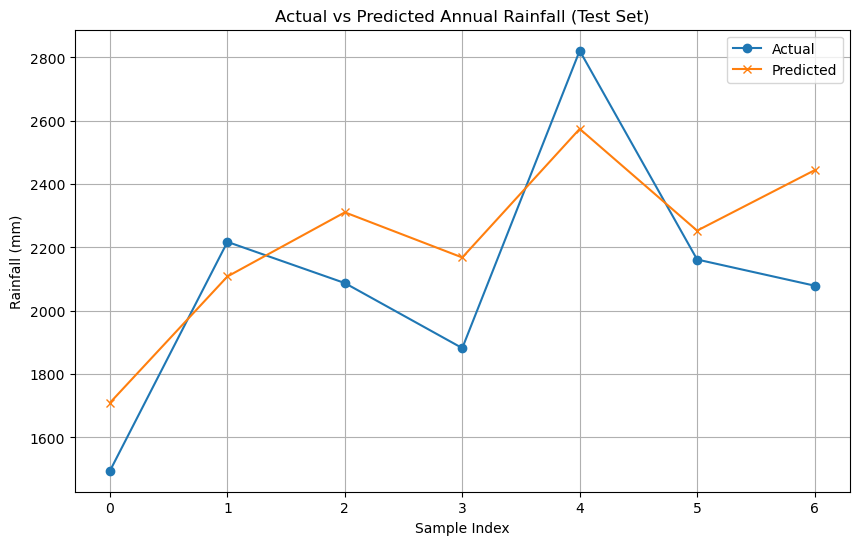


🌧 Predicted Annual Rainfall for 2025: 2584.33 mm

📅 Daily Rainfall Model Evaluation:
Training RMSE: 4.04443155826001
Testing RMSE: 12.15873281096849
R² Score (Test): 0.1832419494556371


Enter a date (YYYY-MM-DD) to predict rainfall:  2025-06-03



📅 Predicted Rainfall on 2025-06-03: ~10.57 mm


Enter a year to predict daily rainfall for:  2025


❌ Year 2025 not found in dataset.

📅 Generating daily rainfall prediction for 2025...


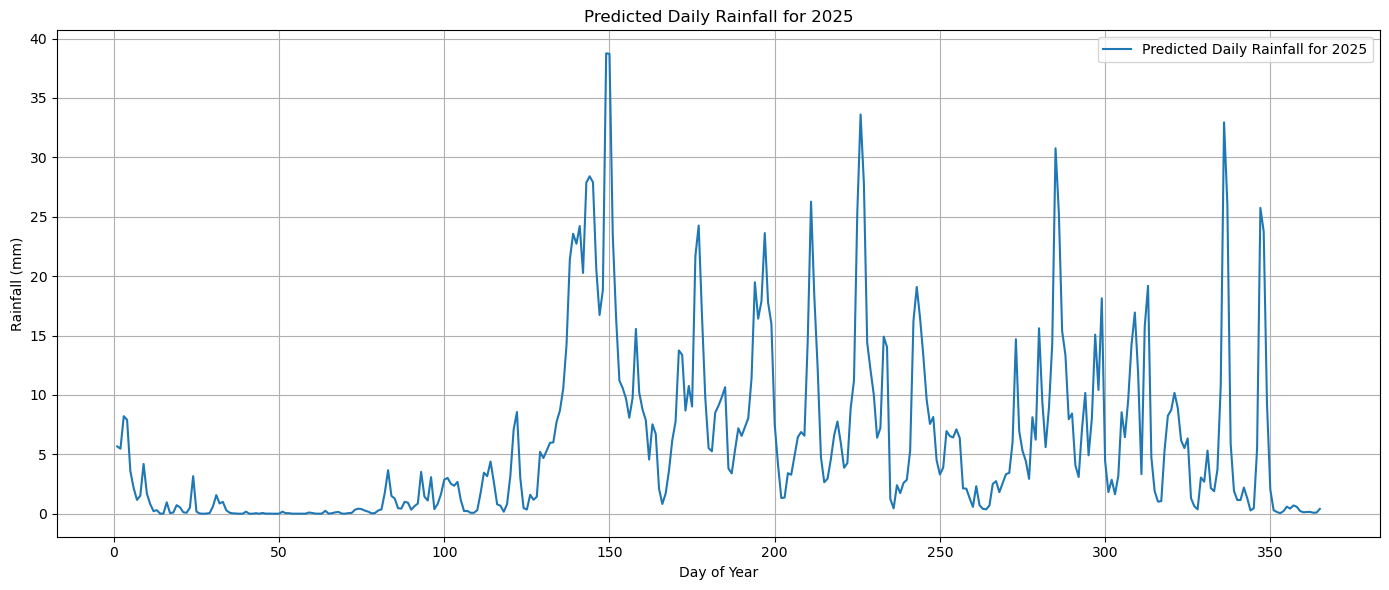

📁 Saved: Predicted_Daily_Rainfall_2025.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# --- Find where the actual CSV data starts ---
file_path = "Peerumade.csv"
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        if line.strip() == '-END HEADER-':
            start_line = i + 1
            break

# --- Load Data ---
df = pd.read_csv(file_path, skiprows=start_line)
print("✅ Data loaded. Shape:", df.shape)
print(df.head())

# --- Preprocessing ---
df.replace(-999, np.nan, inplace=True)
df.dropna(subset=['YEAR', 'DOY', 'PRECTOTCORR'], inplace=True)

df['YEAR'] = df['YEAR'].astype(int)
df['DOY'] = df['DOY'].astype(int)
df['PRECTOTCORR'] = df['PRECTOTCORR'].astype(float)

# --- Feature Engineering ---
df['DATE'] = pd.to_datetime(df['YEAR'] * 1000 + df['DOY'], format='%Y%j', errors='coerce')
df['MONTH'] = df['DATE'].dt.month

# --- Annual and Monsoon Rainfall ---
annual_rainfall = df.groupby('YEAR')['PRECTOTCORR'].sum().reset_index(name='Annual_Rainfall')
monsoon_rainfall = df[df['MONTH'].isin([6, 7, 8, 9])].groupby('YEAR')['PRECTOTCORR'].sum().reset_index(name='Monsoon')
rainfall_df = pd.merge(annual_rainfall, monsoon_rainfall, on='YEAR')

# --- Features and Target for annual model ---
X = rainfall_df[['YEAR', 'Monsoon']]
y = rainfall_df['Annual_Rainfall']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Annual Rainfall Model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions for Annual Model ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# --- Evaluation Metrics Annual Model ---
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n📊 Annual Rainfall Model Evaluation:")
print("Training RMSE:", train_rmse)
print("Training R² Score:", train_r2)
print("Testing RMSE:", test_rmse)
print("Testing R² Score:", test_r2)

# --- Plot: Actual vs Predicted Annual Rainfall ---
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_test_pred, label='Predicted', marker='x')
plt.title("Actual vs Predicted Annual Rainfall (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.show()

# --- Future Prediction for 2025 ---
future = pd.DataFrame({'YEAR': [2025], 'Monsoon': [2500]})
future_pred = model.predict(future)
print(f"\n🌧 Predicted Annual Rainfall for 2025: {future_pred[0]:.2f} mm")

# --- Daily Rainfall Model ---

daily_df = df[['YEAR', 'DOY', 'MONTH', 'PRECTOTCORR']].dropna()
X_daily = daily_df[['YEAR', 'DOY', 'MONTH']]
y_daily = daily_df['PRECTOTCORR']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

daily_model = RandomForestRegressor(n_estimators=100, random_state=42)
daily_model.fit(X_train_d, y_train_d)

# --- Evaluate daily model ---
y_train_d_pred = daily_model.predict(X_train_d)
y_test_d_pred = daily_model.predict(X_test_d)

print("\n📅 Daily Rainfall Model Evaluation:")
print("Training RMSE:", np.sqrt(mean_squared_error(y_train_d, y_train_d_pred)))
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test_d, y_test_d_pred)))
print("R² Score (Test):", r2_score(y_test_d, y_test_d_pred))


# --- Function: Predict rainfall for user input date ---
def predict_rainfall_for_date(input_date_str):
    try:
        input_date = pd.to_datetime(input_date_str)
    except:
        print("❌ Invalid date format. Please use YYYY-MM-DD.")
        return

    input_features = pd.DataFrame({
        'YEAR': [input_date.year],
        'DOY': [input_date.dayofyear],
        'MONTH': [input_date.month]
    })

    predicted_rainfall = daily_model.predict(input_features)[0]
    print(f"\n📅 Predicted Rainfall on {input_date.strftime('%Y-%m-%d')}: ~{predicted_rainfall:.2f} mm")


# --- Function: Predict daily rainfall for any year ---
def predict_daily_rainfall_for_year(year):
    days_year = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')

    predict_year = pd.DataFrame({
        'YEAR': days_year.year,
        'DOY': days_year.dayofyear,
        'MONTH': days_year.month
    })

    predict_year['Predicted_Rainfall_mm'] = daily_model.predict(predict_year)

    plt.figure(figsize=(14, 6))
    plt.plot(predict_year['DOY'], predict_year['Predicted_Rainfall_mm'], label=f'Predicted Daily Rainfall for {year}')
    plt.title(f"Predicted Daily Rainfall for {year}")
    plt.xlabel("Day of Year")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return predict_year


# --- Example Usage: Predict rainfall for user input date ---
user_input_date = input("Enter a date (YYYY-MM-DD) to predict rainfall: ")
predict_rainfall_for_date(user_input_date)

# --- Example Usage: Predict and plot daily rainfall for any year from the dataset ---
year_to_predict = int(input("Enter a year to predict daily rainfall for: "))
if year_to_predict in df['YEAR'].unique():
    predicted_data = predict_daily_rainfall_for_year(year_to_predict)
else:
    print(f"❌ Year {year_to_predict} not found in dataset.")

# --- ✅ NEW: Predict daily rainfall for 2025 directly ---
print("\n📅 Generating daily rainfall prediction for 2025...")
predicted_2025 = predict_daily_rainfall_for_year(2025)
predicted_2025.to_csv("Predicted_Daily_Rainfall_2025.csv", index=False)
print("📁 Saved: Predicted_Daily_Rainfall_2025.csv")
